In [760]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn import preprocessing
import time
import skfuzzy as fuzz
import matplotlib.pyplot as plt

## Preprocessing

In [761]:
# Get the data from source table

data = pd.read_csv('./data/spotify_features_origin.csv')

In [762]:
# Tracks are not unique - some belong to more than one genre

print(f'All tracks: {len(data)}')

#get only unique ids of tracks
unique_ids = pd.unique(data['track_id'])
print(f'Tracks with unique id: {len(unique_ids)}')

All tracks: 232725
Tracks with unique id: 176774


In [763]:
# Get the songs that belong to one genre only

unique_track_id = data.track_id.value_counts()
data_one_genre = data[data.track_id.isin(unique_track_id.index[unique_track_id.eq(1)])]
print(f'Tracks belonging to one genre only: {len(data_one_genre)}')

Tracks belonging to one genre only: 141650


In [764]:
# 26 genres in total
v = data_one_genre.genre.value_counts()
print(f'All genres: {len(v)}')
print(v)

All genres: 26
Comedy              9673
Anime               8556
Reggaeton           8526
Soundtrack          8446
Electronic          8186
Classical           8042
Ska                 8016
World               7961
Opera               7891
Reggae              7689
Movie               7480
Blues               7255
Jazz                7185
Country             6526
Children's Music    6006
Soul                4418
Folk                4342
Dance               2738
R&B                 2725
Indie               1974
Hip-Hop             1903
Rock                1865
Alternative         1817
Pop                 1329
Rap                  982
A Capella            119
Name: genre, dtype: int64


In [765]:
# Get the tracks of 5 genres - Opera, Jazz, Electronic, Pop, Folk
genre_list = ['Opera','Jazz','Electronic','Pop','Folk']
filtered_data = data_one_genre[data_one_genre['genre'].isin(genre_list)]
print (f'Filtered data size: {len(filtered_data)}')

Filtered data size: 28933


In [766]:
# Remove columns that are with discrete (text) values

data_numeric = filtered_data

artist_name_column = data_numeric.pop('artist_name')
track_name_column = data_numeric.pop('track_name')
track_id_column = data_numeric.pop('track_id')
key_column = data_numeric.pop('key')
mode_column = data_numeric.pop('mode')
genre_column = data_numeric.pop('genre')
time_signature_column = data_numeric.pop('time_signature')

In [767]:
# Normalize data - all numeric features have values in the interval [0,1]

x = data_numeric.values # returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data_numeric_norm = pd.DataFrame(x_scaled, index=data_numeric.index, columns=data_numeric.columns)

pd.DataFrame(data_numeric_norm).describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,28933.000000,28933.000000,28933.000000,28933.000000,28933.000000,28933.000000,28933.000000,28933.000000,28933.000000,28933.000000,28933.000000
mean,0.345063,0.505700,0.483412,0.049223,0.474773,0.272460,0.187580,0.715477,0.056407,0.392426,0.365221
std,0.168870,0.400832,0.210606,0.026058,0.295668,0.359378,0.174801,0.142321,0.086159,0.146754,0.264229
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.216495,0.054919,0.318427,0.034802,0.203479,0.000095,0.085106,0.626411,0.016038,0.271496,0.137416
50%,0.371134,0.537148,0.498812,0.044657,0.459969,0.020825,0.111449,0.743952,0.026116,0.382091,0.321668
75%,0.453608,0.936747,0.650032,0.057783,0.735495,0.635815,0.226950,0.825418,0.051149,0.490556,0.558415
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Training phaze

#### K-means ++

In [768]:
# Training with pre-implemented k-means++ algorithm from scikit learn library

kmeans = KMeans(n_clusters = 5, random_state = 0).fit(data_numeric_norm)
crisp_labels = kmeans.labels_

#### Fuzzy C-means

In [769]:
# Initial parameters for the fuzzy c means algorithm implementation

# Number of Attributes
num_attr = len(data_numeric_norm.columns)

# Number of Clusters
k = 5

# Maximum number of iterations
MAX_ITER = 100

# Number of data points
n = len(data_numeric_norm)

# Fuzzy parameter
m = 2.00

In [770]:
def membership_matrix_init():
    membership_mat = np.random.rand(n,k)
    return membership_mat

In [771]:
def calculate_centroids(membership_mat):
    # center of gravity method for defuzzification
    transposed_mm = np.transpose(membership_mat)
    centroids = list()
    for j in range(k):
        vj = transposed_mm[j]
        vj_raised = np.power(vj, m)
        denominator = np.sum(vj_raised) # scalar
        temp = list()
        for i in range(n):
            data_row = np.array(data_numeric_norm.iloc[i])
            product = vj_raised[i] * data_row # mu[i,j] * data_row
            temp.append(product)
        # summation of columns => we get vector with dimensions (num_attr x 1)
        numerator = np.sum(temp, axis = 0)
        center = np.true_divide(numerator, denominator) # divdiding vector by scalar
        centroids.append(center)
    return centroids

In [772]:
def update_membership_matrix(membership_mat, centroids):
    p = 2/(m-1)
    for i in range(n):
        xi = list(data_numeric_norm.iloc[i])
        # l-k norm (i-th data point -> j-th centroid)
        distances = [np.linalg.norm(np.array(xi) - np.array(centroids[j])) for j in range(k)]
        for j in range(k):
            denominator = np.sum([np.power((distances[j]/distances[c]), p) for c in range(k)])
            membership_mat[i][j] = (1/denominator)
    return membership_mat

In [773]:
def get_clusters(membership_mat):
    cluster_labels = list()
    for i in range(n):
        index = np.argmax(membership_mat[i])
        cluster_labels.append(index)
    return cluster_labels

In [774]:
def fuzzy_c_means_clustering():
    # Membership Matrix
    membership_mat = membership_matrix_init()
    for _ in range(MAX_ITER):
        centroids = calculate_centroids(membership_mat)
        membership_mat = update_membership_matrix(membership_mat, centroids)
        cluster_labels = get_clusters(membership_mat)
    print(membership_mat)
    return cluster_labels, centroids

In [775]:
labels, centers = fuzzy_c_means_clustering()
fuzzy_labels = labels

[[0.18939631 0.56287798 0.05347399 0.14618742 0.04806431]
 [0.16795814 0.20562778 0.06801115 0.4533554  0.10504753]
 [0.20818752 0.553586   0.05105977 0.14124326 0.04592346]
 ...
 [0.15679645 0.14204926 0.10969233 0.35013695 0.24132502]
 [0.32753712 0.34290784 0.08599572 0.16815699 0.07540232]
 [0.10456207 0.14119316 0.046896   0.6262292  0.08111957]]


In [776]:
data_labels = pd.DataFrame(data = {'crisp': crisp_labels, 'fuzzy': fuzzy_labels, 'real': genre_column})
data_labels.to_csv('./data/crisp_fuzzy_' + str(int(time.time())) + '.csv', index = False, encoding='utf-8-sig')

## Evaluation of clustering

### Purity

In [777]:
num_fuzzy = 0
num_crisp = 0
for cluster in range(k):
    datapoints_assigned_fuzzy = data_labels.loc[data_labels['fuzzy'] == cluster]
    datapoints_assigned_crisp = data_labels.loc[data_labels['crisp'] == cluster]
    num_fuzzy += datapoints_assigned_fuzzy['real'].value_counts()[0]
    num_crisp += datapoints_assigned_crisp['real'].value_counts()[0]

purity_fuzzy = num_fuzzy/n
purity_crisp = num_crisp/n

print(f'Purity of fuzzy clustering is: {purity_fuzzy}')
print(f'Purity of crisp clustering is: {purity_crisp}')

Purity of fuzzy clustering is: 0.60090554038641
Purity of crisp clustering is: 0.6009401029965783


### Normalized mutual information (NMI)

In [778]:
nmi_fuzzy = normalized_mutual_info_score(data_labels['fuzzy'], data_labels['real'])
nmi_crisp = normalized_mutual_info_score(data_labels['crisp'], data_labels['real'])

print(f'NMI of fuzzy clustering is: {nmi_fuzzy}')
print(f'NMI of crisp clustering is: {nmi_crisp}')

NMI of fuzzy clustering is: 0.32531908988530656
NMI of crisp clustering is: 0.3328621234311072


## Triangular fuzzy membership functions generation

In [779]:
# Concatenate training data (features) and 3 kinds of labels

data_features_labels = pd.concat([data_numeric_norm, data_labels.set_index(data_numeric_norm.index)], axis = 1)

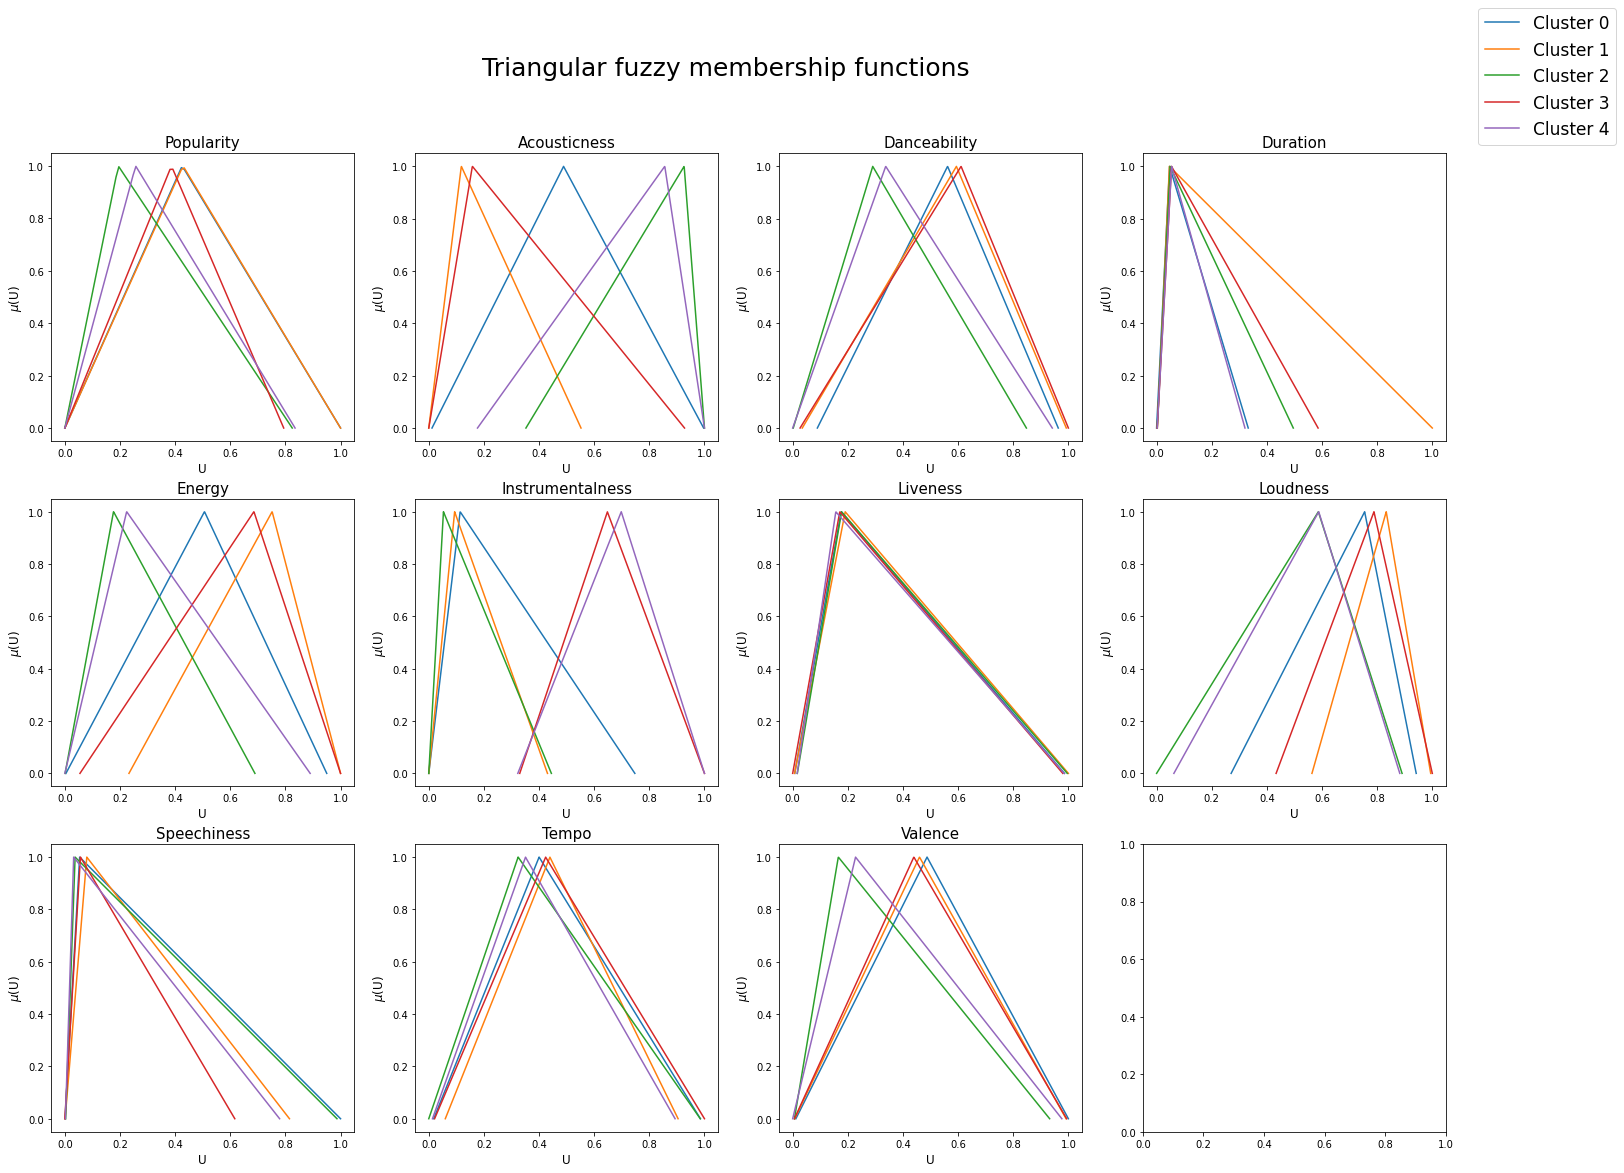

In [784]:
ROWS = 3
COLS = 4

fig, ax = plt.subplots(nrows = ROWS, ncols = COLS, figsize=(25,18))
plt.text(x=0.5, y=0.94, s='Triangular fuzzy membership functions', fontsize=25, ha="center", transform=fig.transFigure)

subplotn = 0

for index_attr, attr in enumerate(data_numeric_norm.columns):

    for cluster in range(k):
        current_cluster = data_features_labels.loc[data_features_labels['fuzzy'] == cluster]
        x = np.sort(current_cluster[attr].to_numpy())
        y = fuzz.trimf(x, [current_cluster[attr].min(), centers[cluster][index_attr], current_cluster[attr].max()])
        current_plot = ax[subplotn // COLS][subplotn % COLS]
        current_plot.plot(x, y)
        current_plot.set_xlabel('U', fontsize = 12)
        current_plot.set_ylabel(r'$\mu$(U)', fontsize = 12)

    subplotn += 1    

ax[0][0].set_title('Popularity', fontsize=15)
ax[0][1].set_title('Acousticness', fontsize=15)
ax[0][2].set_title('Danceability', fontsize=15)
ax[0][3].set_title('Duration', fontsize=15)
ax[1][0].set_title('Energy', fontsize=15)
ax[1][1].set_title('Instrumentalness', fontsize=15)
ax[1][2].set_title('Liveness', fontsize=15)
ax[1][3].set_title('Loudness', fontsize=15)
ax[2][0].set_title('Speechiness', fontsize=15)
ax[2][1].set_title('Tempo', fontsize=15)
ax[2][2].set_title('Valence', fontsize=15)

fig.legend(labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], prop={'size': 17})

In [781]:
for cluster in range(k):
    current_cluster = data_labels.loc[data_labels['fuzzy'] == cluster]
    print(f'Cluster {cluster}:')
    print(current_cluster['real'].value_counts())

Cluster 0:
Jazz          2055
Folk          1646
Pop            461
Electronic     362
Opera           63
Name: real, dtype: int64
Cluster 1:
Electronic    4416
Folk          1269
Jazz          1040
Pop            801
Name: real, dtype: int64
Cluster 2:
Opera         5794
Folk          1000
Jazz           837
Electronic      55
Pop             38
Name: real, dtype: int64
Cluster 3:
Electronic    3087
Jazz          1917
Folk           185
Pop             12
Name: real, dtype: int64
Cluster 4:
Opera         2034
Jazz          1336
Electronic     266
Folk           242
Pop             17
Name: real, dtype: int64
